In [1]:
import geopandas as gpd
import rasterio as rio
from rasterio import features
from rasterio import Affine
import rioxarray as riox
import xarray as xr
import glob
import os
import numpy as np
import re
import pandas as pd

In [2]:
def shp2mask(shp, xr_object, transform, outshape, fill=0, dtype='int16', **kwargs):
    raster = features.rasterize(shp, fill=fill, transform=transform,
                                out_shape=outshape, dtype=dtype, **kwargs)
    return xr.DataArray(raster,
                        coords=(xr_object.coords['y'].values, xr_object.coords['x']),
                        dims=('y', 'x'))

In [3]:
shps_f_list = glob.glob('./ground_data/historical/pDog_*.shp')
cper_f = '/mnt/c/Users/TBGPEA-Sean/Desktop/Pdogs_UAS/cper_pdog_pastures_2017_clip.shp'

In [4]:
cper = gpd.read_file(cper_f)

<AxesSubplot:>

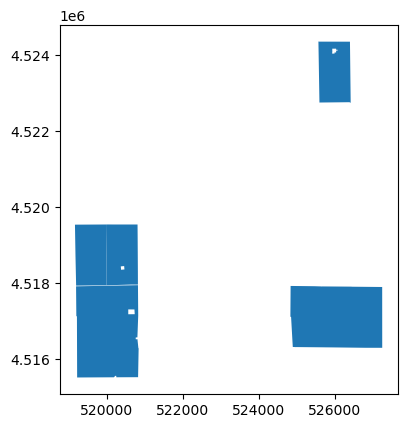

In [5]:
cper.plot()

In [6]:
cell_size = 5.0
transform = rio.transform.from_origin(cper.total_bounds[0],cper.total_bounds[3],cell_size, cell_size)
cper_ras = features.rasterize(zip(cper.geometry, cper.OBJECTID),
                   fill=0, 
                   transform=transform,
                   out_shape=(int(np.ceil((cper.total_bounds[3] - cper.total_bounds[1])/cell_size)),
                              int(np.ceil((cper.total_bounds[2] - cper.total_bounds[0])/cell_size))),
                   dtype=int)

In [7]:
cper_xr = xr.DataArray(cper_ras, 
             coords=(np.arange(cper.total_bounds[3], cper.total_bounds[1], -cell_size),
                    np.arange(cper.total_bounds[0], cper.total_bounds[2], cell_size)),
             dims=('y', 'x'))

In [8]:
cper_xr = cper_xr.where(cper_xr != 0)

In [9]:
shps_f_list

['./ground_data/historical/pDog_2011.shp',
 './ground_data/historical/pDog_2012.shp',
 './ground_data/historical/pDog_2013.shp',
 './ground_data/historical/pDog_2014.shp',
 './ground_data/historical/pDog_2015.shp',
 './ground_data/historical/pDog_2016.shp',
 './ground_data/historical/pDog_2017.shp',
 './ground_data/historical/pDog_2018.shp',
 './ground_data/historical/pDog_2019.shp',
 './ground_data/historical/pDog_2020.shp',
 './ground_data/historical/pDog_2021.shp']

In [10]:
from tqdm import tqdm
yr_xr_list = []
yr_list = []

for f in tqdm(shps_f_list):
    gdf_yr = gpd.read_file(f)
    yr_xr = shp2mask(gdf_yr.geometry, cper_xr, cper_xr.rio.transform(), cper_xr.shape)
    yr_xr_list.append(yr_xr)
    yr_list.append(int(re.sub('.shp', '', f.split('_')[-1])))

100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  8.11it/s]


In [11]:
da_all_yrs = xr.concat(yr_xr_list, pd.Index(yr_list, name='Year'))

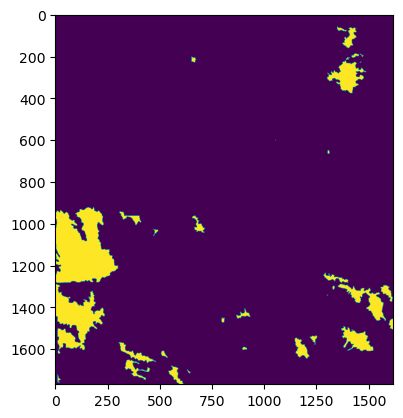

<AxesSubplot:>

In [12]:
from rasterio.plot import show
show(da_all_yrs.sel(Year=2020).data)

In [13]:
da_active = da_all_yrs.sel(Year=2021)
da_active = da_active + ((da_all_yrs.sel(Year=2021) == 1) & 
                            (da_all_yrs.sel(Year=2020) == 0))
da_active = da_active + ((da_all_yrs.sel(Year=2021) == 1) & 
                               (da_all_yrs.sel(Year=2020) == 1))
da_active = da_active + ((da_all_yrs.sel(Year=2021) == 1) & 
                               (da_all_yrs.sel(Year=2020) == 1) & 
                               (da_all_yrs.sel(Year=2019) == 1))
da_active = da_active + ((da_all_yrs.sel(Year=2021) == 1) & 
                               (da_all_yrs.sel(Year=2020) == 1) & 
                               (da_all_yrs.sel(Year=2019) == 1)  & 
                               (da_all_yrs.sel(Year=2018) == 1))
da_active = da_active + ((da_all_yrs.sel(Year=2021) == 1) & 
                               (da_all_yrs.sel(Year=2020) == 1) & 
                               (da_all_yrs.sel(Year=2019) == 1) & 
                               (da_all_yrs.sel(Year=2018) == 1) & 
                               (da_all_yrs.sel(Year=2017) == 1))

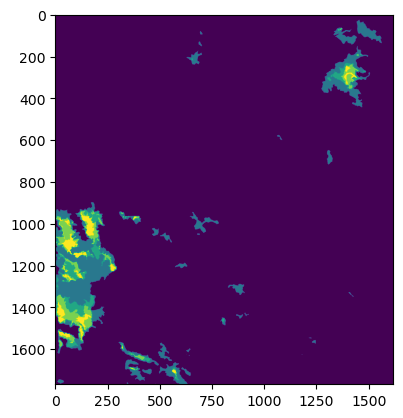

<AxesSubplot:>

In [14]:
show(da_active.data)

In [15]:
da_old = (da_all_yrs.sel(Year=2021) == 0) * 5.0
da_old = da_old - ((da_all_yrs.sel(Year=2021) == 0) & 
                   (da_all_yrs.sel(Year=2020) == 1))
da_old = da_old -  ((da_all_yrs.sel(Year=2021) == 0) & 
                   (da_all_yrs.sel(Year=2020) == 0) &
                   (da_all_yrs.sel(Year=2019) == 1))
da_old = da_old - ((da_all_yrs.sel(Year=2021) == 0) & 
                   (da_all_yrs.sel(Year=2020) == 0) &
                   (da_all_yrs.sel(Year=2019) == 0) &
                   (da_all_yrs.sel(Year=2018) == 1))
da_old = da_old - ((da_all_yrs.sel(Year=2021) == 0) & 
                   (da_all_yrs.sel(Year=2020) == 0) &
                   (da_all_yrs.sel(Year=2019) == 0) &
                   (da_all_yrs.sel(Year=2018) == 0) &
                   (da_all_yrs.sel(Year=2017) == 1))
da_old = da_old.where(da_all_yrs.sel(Year=2021) == 0)

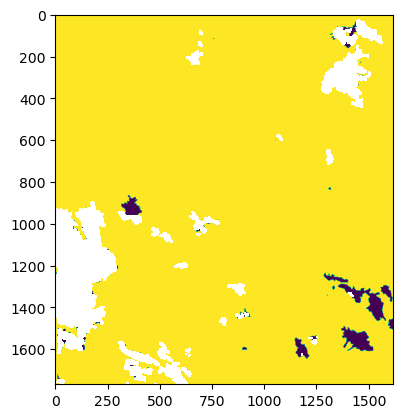

<AxesSubplot:>

In [16]:
show(da_old.data)

In [18]:
da_active.where(cper_xr.notnull()).rio.to_raster('./ground_data/PdogMapping_Sept2021/Sept2021_active_yrs.tif')
da_old.where(cper_xr.notnull()).rio.to_raster('./ground_data/PdogMapping_Sept2021/Sept2021_old_yrs.tif')

In [37]:
da_old_any = ((da_all_yrs.sel(Year=2021) == 0) & 
                   ((da_all_yrs.sel(Year=2020) == 1) |
                   (da_all_yrs.sel(Year=2019) == 1) |
                   (da_all_yrs.sel(Year=2018) == 1) |
                   (da_all_yrs.sel(Year=2017) == 1)))

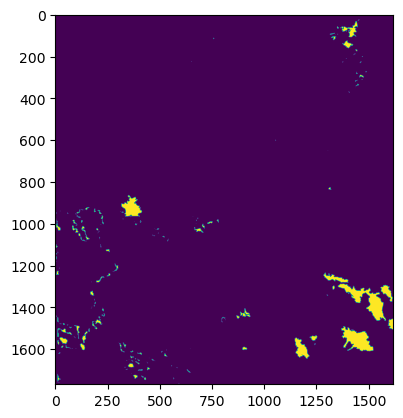

<AxesSubplot:>

In [38]:
show(da_old_any.data)

In [118]:
da_all_yrs = da_all_yrs.sortby('Year').where(cper_xr.notnull())